# Confidence Intervals for Estimates

In the previous section, I gave an overview of estimation and its properties, and we presented particular examples of the mean and variance estimators. Recall that estimators are random variables, which means that any particular estimate comes from a random distribution. It is helpful to characterize the uncertainty in an estimate, and the usual way that we do this is by providing a confidence interval with the estimate.

## Bootstrap Confidence Intervals for Estimates

If we estimate parameters of a distribution from a data set and only return the estimated values, those are called point estimates. Point estimates are limited in their usefulness because they do not give any indication of the reliability of those estimates. To provide more information, it is helpful to specify confidence intervals for the parameters. We will use bootstrap sampling to generate confidence intervals. 

In the simulation below, 20 random values are drawn from a Normal(1, 2) distribution. Then the sample mean is calculated, and bootstrap sampling is used to also generate a 95% confidence interval. This process is repeated to show the sample mean and the confidence interval for 25 different random samples. The star marker indicates the average (sample mean) of the data, and the vertical line indicates the true mean (1). Confidence intervals that contain the true mean are indicated as solid, green lines; confidence intervals that do not contain the true mean are indicated by dashed, red/orange lines.  


Text(0.5, 1.0, 'Confidence Intervals for 25 Random Samples of Normal Data')

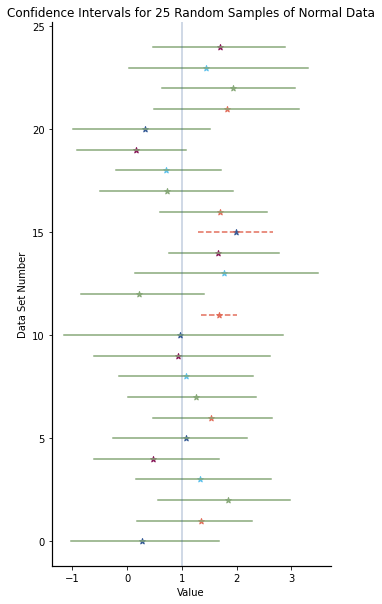

In [9]:
import numpy.random as npr
npr.seed(5678)

num_sims = 25
data_size = 10

X = stats.norm(1,2 )

plt.figure(figsize = (5,10) )
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [2.5, 97.5])
  if percentiles[0] <= 1 and percentiles[1] >=1:
    plt.plot(percentiles, [sim, sim], color='C2')
  else:
    plt.plot(percentiles, [sim, sim], color='C1', linestyle='--')
  plt.scatter(avg, sim, marker='*')
 
plt.axvline(1, alpha=0.3)
plt.ylabel('Data Set Number');
plt.xlabel('Value');
plt.title('Confidence Intervals for 25 Random Samples of Normal Data')


For the seed I arbitrarily chose, 2 out of 25 confidence intervals did not contain the true mean, which is 8%. In the long run, we expect at least 5% of confidence intervals to not contain the true mean, and the bootstrap estimator for CIs is not conservative enough for small data, so 8% may be accurate. The following simulation provides a more accurate estimate of the probability that the CI contains the true mean by running 1,000 simulations:

In [10]:
num_sims = 2000
data_size = 10

X = stats.norm(1,2 )

num_miss_true_mean = 0
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [2.5, 97.5])
  if percentiles[0] > 1 or percentiles[1] <1:
    num_miss_true_mean += 1

print('The probabilty a bootstrap CI does not contain the true mean is' 
      + f'{num_miss_true_mean/num_sims : 0.2f}')

The probabilty a bootstrap CI does not contain the true mean is 0.10


We see that the actual that a bootstrap CI does not contain the true mean for this distribution is around 11%, when our target was 5%. Below is a table that shows the probability[^ci_probs] that a bootstrap sample does not contain the true mean for this distribution as a function of $N$:

| Data Size ($N$) | Probability CI does not contain true mean |
| :-: | :-: |
| 5 | 16.3% |
| 10 | 10.0% |
| 25 | 6.9% |
| 50 | 5.9% |
| 75 | 5.6% |
| 100 | 5.5% |

Based on this distribution, bootstrap confidence intervals can only be considered accurate if they are generated from more than 100 data samples. However, better confidence intervals can be generated through bootstrap sampling using algorithms such as the $\mbox{BC}_\alpha$ method or $\mbox{ABC}$ method[^efron_book], which are available in the Python [bootstrap-stat library](https://pypi.org/project/bootstrap-stat/).

We will continue to use percentile-based bootstrap confidence intervals in this book for simplicity, but readers who need more accurate results should use one of the two algorithms mentioned above.

[^ci_probs]: These probabilities are approximations; they were estimated via simulations of 100,000 random samples of the data for each data size.

[^efron_book]: See Chapter 14 of *An Introduction to the Bootstrap* by Bradley Efron and Robert J. Tibshirani, Chapman & Hall/CRC, 1993.

In [20]:
from numba import jit


In [21]:
@jit
def sim_ci(data_size=5, num_sims=100_000):

  num_bs_sims = 1000
  X = stats.norm(1,2 )

  num_miss_true_mean = 0
  Xvals = X.rvs((num_sims, data_size))
  avgs = Xvals.mean(axis=1)
  bs_averages = np.zeros(num_bs_sims)
  for sim in range(num_sims):

    # Do bootstrap sampling

    for bs_sim in range(num_bs_sims):
      bs_sample = npr.choice(Xvals[sim], data_size)
      bs_avg = bs_sample.mean()
      bs_averages[bs_sim] = bs_avg

    percentiles = np.percentile(bs_averages, [2.5, 97.5])
    if percentiles[0] > 1 or percentiles[1] <1:
      num_miss_true_mean += 1

  #print('The probabilty a bootstrap CI does not contain the true mean is' 
       # + f'{num_miss_true_mean/num_sims*100 : 0.2f}')
  return num_miss_true_mean/num_sims*100

In [22]:
for data_size in [5, 10, 25, 50, 75, 100]:
  print(data_size, f'{sim_ci(data_size) : 0.1f}' )

/var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_70531/4212116520.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sim_ci" failed type inference due to: Unknown attribute 'norm' of type Module(<module 'scipy.stats' from '/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/__init__.py'>)

File "../../../../../../../../var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_70531/4212116520.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_70531/4212116520.py (5)

File "../../../../../../../../var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_70531/4212116520.py", line 5:
<source missing, REPL/exec in use?>

  @jit
/var/folders/gz/d_8lq2wn23x2lmhfh63cfl3400010v/T/ipykernel_70531/4212116520.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "sim_ci" f

5  16.3
10  10.0
25  6.9
50  5.9
75  5.6
100  5.5


## Analytical Confidence Intervals for Mean Estimates

The mean is special because of the Central Limit Theorem (see {doc}`Section 8.7.3.2<../08-random-variables/important-continuous-rvs>`) -- regardless of the type of distribution of the underlying data[^clt], the distribution of the sample mean estimator will be approximately Normal if there are at least tens of data points. Given the distribution of the estimator, we can use analytical approaches as an alternative to bootstrap estimators. The first step is to characterize the parameters of the distribution of the sample mean estimator.

[^clt]: Actually the distribution will have to satisfy some mild restrictions, such as having finite mean and variance.

### Linear Combinations of Independent Gaussian RVs

Suppose we have a  data sample $\mathbf{X}=\left[X_0,X_1,\cdots,X_{n_X-1} \right]$, where different values in the sample are assumed to be independent[^ci]. We know from above that the sample mean estimator is unbiased. Thus, the expected value of the sample mean estimator is the true mean. We will also need the variance of the sample mean estimator in our analysis. Let $\sigma_{X}^2$ be the variance of the $X_i$. Then the variance of the sample mean estimator is 
\begin{align*}
\operatorname{Var} \left[ \hat{\mu}_X \right] &= \operatorname{Var} \left[ \frac 1 {n_X} \sum_{i=0}^{n_X-1} X_i \right] \\
&= \frac 1 {n_{X}^2} \operatorname{Var} \left[  \sum_{i=0}^{n_X-1} X_i \right], \\
\end{align*}
where the second line of the equation follows from Property 3 of variance (see {doc}`Section 9.3.4<moments>`). Since the random variables in $\mathbf{X}$ are independent, we can apply Property 4 of variance to get
\begin{align*}
\operatorname{Var} \left[ \hat{\mu}_X \right] &= \frac 1 {n_{X}^2}  \sum_{i=0}^{n_{X}-1} \operatorname{Var} \left[  X_i \right] \\
&= \frac 1 {n_{X}^2}  \sum_{i=0}^{n_{X}-1} \sigma_{X}^2\\
&= \frac 1 {n_{X}^2}  n_{X} \sigma_{X}^2\\
&= \frac {\sigma_{X}^2} {n_{X}}  .
\end{align*}
The variance of the sample mean estimator decreases linearly with the number of samples. (This can be used to show that the sample mean estimator converges to the true mean as $n_{X} \rightarrow \infty$ if $\sigma_{X}^2$ is finite.)

The analysis above is sufficient to characterize $\hat{\mu}_X$ :
\begin{align*}
\hat{\mu}_X \sim \mbox{Normal} \left(\mu_X, \frac{\sigma_X}{\sqrt{n_X}} \right) .
\end{align*}


Note however, that $\mu_X$ is unknown (it is the parameter we are trying to estimate), and $\sigma_X$ may be known but is more often also unknown and must be estimated from the data. The analysis of the confidence intervals is different depending on whether the standard deviation of the data is known or unknown.

### Confidence Intervals for Mean Estimate with Known Data Variance

Recall that given a specified confidence $C$%, we wish to create a procedure that for each data sample $\mathbf{x}$ will determine an interval $I_C$ such that $P( \mu_X \in I_C) = C\%$, where $\mu_X$ is the true mean, which is unknown. Then for a particular data sample $\mathbf{x}$ with average $\overline{\mathbf{x}}$, we can calculate the probability of observing an average "as extreme" as $\overline{\mathbf{x}}$ for any given value of $\mu_X$. 

\begin{align*}
P\left( \mu  \in \left( \hat{\mu}_X -d, \hat{\mu}_X +d \right] \right) \\
P\left(  \hat{\mu}_X -d \le \mu \cap \hat{\mu}_X +d > \mu \right) \\
P\left(  \hat{\mu}_X  - \mu \le d \cap \hat{\mu}_X -\mu  > -d\right) \\
\end{align*}

Observing that $\hat{\mu}_X-\mu$ has mean zero, we start by rewriting this expression in terms of tail probabilities:
\begin{align*}
P\left(  \hat{\mu}_X  - \mu \le d \cap \hat{\mu}_X -\mu  > -d\right)  &= 
1 - P\left(  \hat{\mu}_X  - \mu > d \cup \hat{\mu}_X -\mu  \le  -d\right) \\
&= 1 - P\left(  \hat{\mu}_X  - \mu > d \right) + P\left(\hat{\mu}_X -\mu  \le  -d\right),
\end{align*}
where the second line comes from the fact that we are asking about the probability that $\hat{\mu}_X -\mu $ is in mutually exclusive regions of the real line, which results in mutually exclusive events. Next note that under the assumption that $\hat{\mu}_X - \mu$ is normal with mean 0, the pdf of $\hat{\mu}_X - \mu$  is symmetric around $x=0$. We can use this symmetry to write 
\begin{align*}
 1 - P\left(  \hat{\mu}_X  - \mu > d\right) + P\left(\hat{\mu}_X -\mu  \le  -d\right) =  1 - 2 P\left(  \hat{\mu}_X  - \mu > d \right).
\end{align*}

Then for a given confidence C, we have 
\begin{align*}
 1 - 2 P\left(  \hat{\mu}_X  - \mu > d \right) &= C \\
 P\left(  \hat{\mu}_X  - \mu > d \right) = \frac{1-C}{2}.
\end{align*}
For future convenience, let $\alpha = (1-C)/2$.

We have several ways to proceed from here. One approach is to create a SciPy distribution for the random variable $\hat{\mu}_X  - \mu$, which we know is Normal with mean 0. The variance of  $\hat{\mu}_X$ is $\sigma_{X}^2/\sqrt{n}$, and this is also the variance of  $\hat{\mu}_X  - \mu$ by Property 2 of variance. Note that the probability is in the form of a survival function, which is the $Q$ function for a Normal random variable. Since we have SciPy available, the simplest and most direct way is to make a Normal distribution object with the appropriate mean and variance and use the inverse survival function method `isf()` to solve for the value of $d$. The code below shows hot to find the value of $d$ for a 95% confidence interval when $\sigma=2$:

In [60]:
x_var = np.var(x, ddof=1)
n = 10
alpha = (1-0.95)/2

T = stats.norm(loc = 0, scale = 2 / np.sqrt(n) )
T.isf(alpha)

1.2395900646091231

As an alternative to setting up a Normal random variable with the specified standard deviation and using the `isf()` function, we can express the probability analytically in terms of the $Q$ function as 
\begin{align*}
 Q\left(  \hat{\mu}_X  - \mu > d \right) &= \alpha \\
 \frac d {\sigma_x/\sqrt{n_x}}  &= Q^{-1} \left(\alpha \right) \\
d &= \frac{\sigma_x}{\sqrt{n_x}} Q^{-1} \left(\alpha \right) \\
\end{align*}



Then we can use our usual definition of the $Q$ function in Python to calculate the value of $d$. The code below shows how the calculation for the same scenario of $C=95$% and $\sigma_X=2$:

In [59]:
def qinv(x):
  return stats.norm.isf(x)

In [61]:
sigma_x = 2
n = 10
alpha = (1-0.95)/2


sigma_x / np.sqrt(n) * qinv(alpha)


1.2395900646091231

The figure below compares the bootstrap confidence interval to the analytical confidence interval for the same data as in the previous example, which considered only bootstrapping.


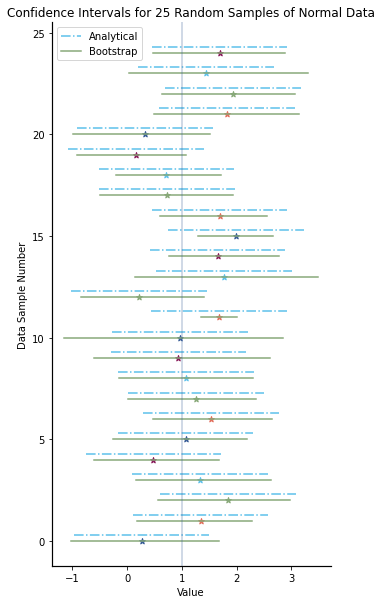

In [23]:
import numpy.random as npr
npr.seed(5678)

num_sims = 25
data_size = 10

X = stats.norm(1,2 )
d = 2 / np.sqrt(10) * qinv((1-0.95)/2)

plt.figure(figsize = (5,10) )
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  avg = Xvals.mean()
  
  # Now do bootstrap sampling
  num_bs_sims = 1000
  bs_averages = np.zeros(num_bs_sims)
  for bs_sim in range(num_bs_sims):
    bs_sample = npr.choice(Xvals, data_size)
    bs_avg = bs_sample.mean()
    bs_averages[bs_sim] = bs_avg
    
  percentiles = np.percentile(bs_averages, [2.5, 97.5])

  if sim ==0:
    plt.plot([avg-d, avg+d], [sim+0.3, sim+0.3], color='C3', linestyle='-.', label = 'Analytical')
    plt.plot(percentiles, [sim, sim], color='C2', label = 'Bootstrap')
  else:
    plt.plot(percentiles, [sim, sim], color='C2')
    plt.plot([avg-d, avg+d], [sim+0.3, sim+0.3], color='C3', linestyle='-.')
    
  plt.scatter(avg, sim, marker='*')
 
plt.axvline(1, alpha=0.3)
plt.ylabel('Data Sample Number');
plt.xlabel('Value');
plt.legend();
plt.title('Confidence Intervals for 25 Random Samples of Normal Data');


Note that for most of the results, the confidence intervals returned by the bootstrap algorithm and the analytical result are approximately equal. However, there are several important differences. In particular, the bootstrap algorithm produces two confidence intervals that are much narrower than the analytical confidence intervals and that do not include the true mean -- these are for data samples 11 and 15. The smaller bootstrap confidence intervals can be attributed to those data sample having a much smaller sample variance than the variance of the distribution from which they came. Recall that the data comes from a distribution with standard deviation of 2, corresponding to a variance of 4. The figure below shows the sample variances for each of the data samples in this example, with the values for samples 11 and 15 highlighted in orange:

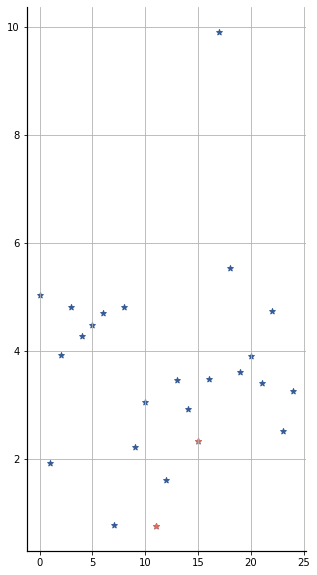

In [32]:
npr.seed(5678)

num_sims = 25
data_size = 10

X = stats.norm(1,2 )
small_cis=[11, 15]

plt.figure(figsize = (5,10) )
variances = []
for sim in range(num_sims):
  Xvals = X.rvs(data_size)
  #avg = Xvals.mean()
  var = Xvals.var(ddof=1)
  variances += [var]
      
plt.scatter(range(num_sims), variances, marker='*')

for sim in small_cis:
  plt.scatter(sim, variances[sim], marker='*', color='C1')
plt.grid();

 
# plt.axvline(1, alpha=0.3)
# plt.ylabel('Data Sample Number');
# plt.xlabel('Value');
# plt.legend();
# plt.title('Confidence Intervals for 25 Random Samples of Normal Data');



Note that having a low sample variance does not necessarily imply that the bootstrap confidence interval will be small. The sample variance for data sample 7 is similar to that of data sample 11, and yet the confidence interval for data sample 7 is not that smaller than the analytical result. This can be attributed to the fact that the bootstrap uses all of the information in the data rather than just the variance when creating the confidence intervals.

This example shows that analysis can produce better estimates of confidence intervals, but it **required that the standard deviation of the distribution be known**. In most practical examples, this is not the case, and the standard deviation or variance must be estimated from the data. 

### Confidence Intervals for Mean Estimate with Unknown Data Variance

If the standard deviation or variance of the distribution is not known, then we must estimate it. We will use the unbiased sample mean estimator, 
\begin{align*}
S_{n-1}^2 = \frac{1}{n-1}\sum_{i=0}^{n-1} \left(X_i-\hat{\mu}_X \right)^2.
\end{align*}


Recall that if $\hat{\mu}_X$ is Normal( $\mu_X, \sigma_X)$ , then 
```{math}
:label: normalized1
\frac{ X  - \mu_X}{\sigma_X} \sim \mbox{Normal}(0,1).
```
<!-- $$ \frac{ X  - \mu_X}{\sigma_X} \sim \mbox{Normal}(0,1). $$-->

If we have to replace the true mean and variance by their estimators, then the distribution changes. Consider a case where we have $n$ samples with an unbiased variance estimate, 
$S_{n-1}$. Then the distribution of
```{math}
:label: normalized2
\frac{\hat{\mu}-\mu_X }{S_{n-1}/\sqrt{n}}
```
has a **Student’s $t$-distribution with $\nu = n-1$ degrees of freedom (dof)**.  For convenience, we will denote such as distribution by $t_\nu$.


The density and distribution functions are complicated and omitted here, but you can find them on the [Wikipedia page for Student's $t$-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution). Fortunately for us, SciPy.stats has the functions we will need in our analysis built in. An additional point of good news is that unlike the Gaussian distribution, the distribution function for Student’s t-distribution is in closed form for several values of the dof parameter.

```{note}
Note that normalizing by the true mean and variance, as in  {eq}`normalized1` results in a random variable with mean 0 and variance 1. 

The normalization in {eq}`normalized2` results in a random variable with mean 0 and variance equal $\nu/(\nu-2)$ for $\nu>2$, where $\nu=n-1$ is the number of degrees of freedom of the Student's $t$ distribution. Note that the variance of the Student's $t$ distribution is always greater than 1 but converges to 1 for large $\nu$.
```

Let's compare the standard Normal(0,1) density to the Student's $t$ density with different dofs:

In [33]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

norm=stats.norm()
t1=stats.t(1)
t2=stats.t(2)
t5=stats.t(5)
tinf=stats.t(100000)

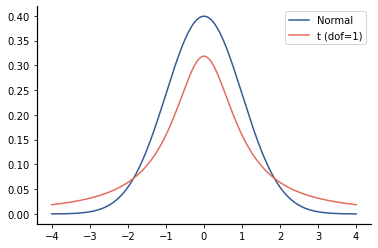

In [34]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,t1.pdf(x),label='t (dof=1)')
plt.legend();

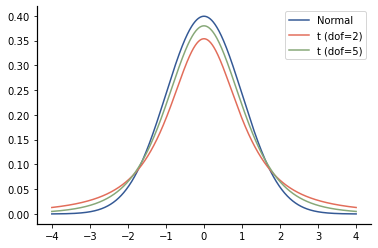

In [35]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,t2.pdf(x),label='t (dof=2)')
plt.plot(x,t5.pdf(x),label='t (dof=5)')
plt.legend();

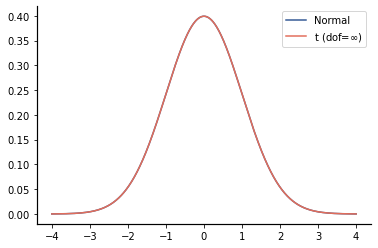

In [36]:
x=np.linspace(-4,4,1000)
plt.plot(x,norm.pdf(x),label='Normal')
plt.plot(x,tinf.pdf(x),label='t (dof=$\infty$)')
plt.legend();

For small dofs, the Student's $t$ density has much more probability in the tails of the distribution than the Normal density does. As $N \rightarrow \infty$, the Student's $t$ density converges to the Normal density.

**JMS: WORKING HERE**

If we want to generate a SciPy distribution for a Student's $t$ variable of the form in {eq}`normalized2`, then we can set the `loc` paramater of `stats.t` to the value of $\mu_X$ and the `scale` parameter to the value of the denominator, $S_{n-1}/\sqrt{n}$. For instance, we will often be working with a $t$ variable with mean 0. If we have data in a variable `x`, then we can generate a SciPy $t$-distribution as follows:

In [45]:
# Some sample data
x = [-9, -4, 1, 4, 9, 16]

n = len(x)
sigma_t = np.var(x, ddof=1) / np.sqrt(len(x))
T = stats.t(df = n-1, scale = sigma_t)

The average value is

In [46]:
np.mean(x)

2.8333333333333335

If the true mean were 0, the probability of seeing such a large value of the mean can be computed using the `T` object as

In [47]:
T.sf(np.mean(x))

0.46734814295936844

**Example**

Consider again generating analytical confidence intervals for the mean of data samples consisting of 10 random values, where those values are independent samples from the Normal(1, 2) distribution, but where the standard deviation now has to be estimated from the data. 



Now that we have a better understanding of parameter estimation, we  revisit hypothesis testing for a difference of means in the next section.

In [25]:
variances

[5.031391710530517]